In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, classification_report
from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
fer_directory = 'data/FER2013'
ck_directory = 'data/CK+'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tensorflow version: 2.10.1
Num GPUs Available:  1


In [3]:
def plot_model_training(history):
    # Plot training & validation accuracy values
    plt.figure(facecolor='white')
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy', fontsize=20)
    plt.ylabel('Accuracy', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.figure(facecolor='white')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss', fontsize=20)
    plt.ylabel('Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=16)
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def calculate_model_metrics(y_true, y_pred, classes):
    # Calculate metrics
    print(classification_report(y_true, np.argmax(y_pred, axis=1), target_names=classes))

    # Calculate Precision, Recall, F1 score
    precision, recall, fscore, support = precision_recall_fscore_support(y_true, np.argmax(y_pred, axis=1), average='macro')
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", fscore)
    
    return precision, recall, fscore

def plot_confusion_matrix(y_true, y_pred, classes):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot()
    plt.show()

<h1>Test with different input sizes</h1>

In [8]:
# Initialise generator with rescale factor 1./255
train_gen = ImageDataGenerator(rescale=1./255, rotation_range=10,  zoom_range=0.1, horizontal_flip=True)
test_gen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

# 48 x 48
# Preprocess training set
train_generator_48 = train_gen.flow_from_directory(
    fer_directory + '/train',
    target_size=(48,48),
    batch_size=128,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True
)

validation_generator_48 = test_gen.flow_from_directory(
    fer_directory + '/test',
    target_size=(48,48),
    batch_size=128,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


# 72 x 72
train_generator_54 = train_gen.flow_from_directory(
    fer_directory + '/train',
    target_size=(54,54),
    batch_size=128,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True
)

validation_generator_54 = test_gen.flow_from_directory(
    fer_directory + '/test',
    target_size=(54,54),
    batch_size=128,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# 96 x 96
train_generator_60 = train_gen.flow_from_directory(
    fer_directory + '/train',
    target_size=(60,60),
    batch_size=128,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True
)

validation_generator_60 = test_gen.flow_from_directory(
    fer_directory + '/test',
    target_size=(60,60),
    batch_size=128,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

# Might need to up the target size to match the model input size
# Preprocess test set
# False shuffle so classification dont get mixed
test_generator = test_gen.flow_from_directory(
    fer_directory + '/test',
    target_size=(48,48),
    batch_size=128,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training', # Doesnt really matter just splitting test data into 50 50
    shuffle=False
)

Found 28709 images belonging to 7 classes.
Found 3587 images belonging to 7 classes.
Found 28709 images belonging to 7 classes.
Found 3587 images belonging to 7 classes.
Found 28709 images belonging to 7 classes.
Found 3587 images belonging to 7 classes.
Found 3591 images belonging to 7 classes.


In [10]:
# Get steps per epoch
steps_per_epoch = train_generator_48.n//train_generator_48.batch_size
validation_steps = validation_generator_48.n//validation_generator_48.batch_size

# Get classes and y labels
classes = list(test_generator.class_indices.keys())
y_true = test_generator.classes

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, min_lr=0.00001, mode='max', verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, patience=10, verbose=1, restore_best_weights=True)

In [5]:
model_48 = Sequential()

model_48.add(Conv2D(256, (3,3), padding='same', input_shape=(48,48,1), activation='relu'))
model_48.add(Conv2D(384, (3,3), padding='same', activation='relu'))
model_48.add(BatchNormalization())
model_48.add(MaxPooling2D(pool_size=(2,2)))
model_48.add(Dropout(0.4))

model_48.add(Conv2D(320, (3,3), padding='same', activation='relu'))
model_48.add(BatchNormalization())
model_48.add(MaxPooling2D(pool_size=(2,2)))
model_48.add(Dropout(0.4))

model_48.add(Conv2D(192, (3,3), padding='same', activation='relu'))
model_48.add(BatchNormalization())
model_48.add(MaxPooling2D(pool_size=(2,2)))
model_48.add(Dropout(0.4))

model_48.add(Conv2D(192, (3,3), padding='same', activation='relu'))
model_48.add(BatchNormalization())
model_48.add(MaxPooling2D(pool_size=(2,2)))
model_48.add(Dropout(0.4))

model_48.add(Flatten())
model_48.add(Dense(352, activation='relu'))
model_48.add(BatchNormalization())

model_48.add(Dropout(0.4))
model_48.add(Dense(7, activation='softmax'))

model_48.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
model_48.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 48, 48, 256)       2560      
                                                                 
 conv2d_6 (Conv2D)           (None, 48, 48, 384)       885120    
                                                                 
 batch_normalization_5 (Batc  (None, 48, 48, 384)      1536      
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 384)      0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 384)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 320)      

In [4]:
model_54 = Sequential()

model_54.add(Conv2D(256, (3,3), padding='same', input_shape=(54,54,1), activation='relu'))
model_54.add(Conv2D(384, (3,3), padding='same', activation='relu'))
model_54.add(BatchNormalization())
model_54.add(MaxPooling2D(pool_size=(2,2)))
model_54.add(Dropout(0.4))

model_54.add(Conv2D(320, (3,3), padding='same', activation='relu'))
model_54.add(BatchNormalization())
model_54.add(MaxPooling2D(pool_size=(2,2)))
model_54.add(Dropout(0.4))

model_54.add(Conv2D(192, (3,3), padding='same', activation='relu'))
model_54.add(BatchNormalization())
model_54.add(MaxPooling2D(pool_size=(2,2)))
model_54.add(Dropout(0.4))

model_54.add(Conv2D(192, (3,3), padding='same', activation='relu'))
model_54.add(BatchNormalization())
model_54.add(MaxPooling2D(pool_size=(2,2)))
model_54.add(Dropout(0.4))

model_54.add(Flatten())
model_54.add(Dense(352, activation='relu'))
model_54.add(BatchNormalization())

model_54.add(Dropout(0.4))
model_54.add(Dense(7, activation='softmax'))

model_54.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
model_54.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 256)       2560      
                                                                 
 conv2d_1 (Conv2D)           (None, 54, 54, 384)       885120    
                                                                 
 batch_normalization (BatchN  (None, 54, 54, 384)      1536      
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 384)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 27, 27, 384)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 27, 27, 320)       1

In [6]:
model_60 = Sequential()

model_60.add(Conv2D(256, (3,3), padding='same', input_shape=(60,60,1), activation='relu'))
model_60.add(Conv2D(384, (3,3), padding='same', activation='relu'))
model_60.add(BatchNormalization())
model_60.add(MaxPooling2D(pool_size=(2,2)))
model_60.add(Dropout(0.4))

model_60.add(Conv2D(320, (3,3), padding='same', activation='relu'))
model_60.add(BatchNormalization())
model_60.add(MaxPooling2D(pool_size=(2,2)))
model_60.add(Dropout(0.4))

model_60.add(Conv2D(192, (3,3), padding='same', activation='relu'))
model_60.add(BatchNormalization())
model_60.add(MaxPooling2D(pool_size=(2,2)))
model_60.add(Dropout(0.4))

model_60.add(Conv2D(192, (3,3), padding='same', activation='relu'))
model_60.add(BatchNormalization())
model_60.add(MaxPooling2D(pool_size=(2,2)))
model_60.add(Dropout(0.4))

model_60.add(Flatten())
model_60.add(Dense(352, activation='relu'))
model_60.add(BatchNormalization())

model_60.add(Dropout(0.4))
model_60.add(Dense(7, activation='softmax'))

model_60.compile(optimizer=Adam(learning_rate=0.0001, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
model_60.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 60, 60, 256)       2560      
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 384)       885120    
                                                                 
 batch_normalization_10 (Bat  (None, 60, 60, 384)      1536      
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 30, 30, 384)      0         
 2D)                                                             
                                                                 
 dropout_10 (Dropout)        (None, 30, 30, 384)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 30, 30, 320)      

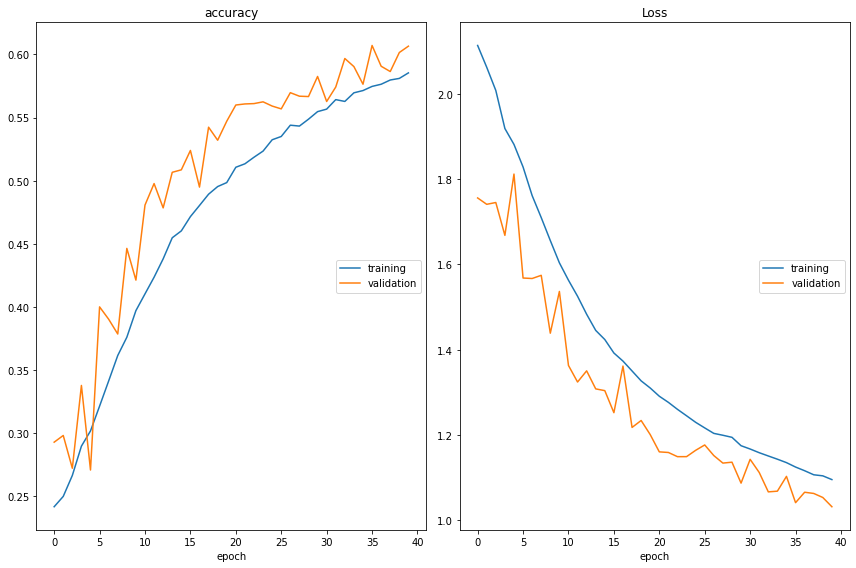

accuracy
	training         	 (min:    0.242, max:    0.585, cur:    0.585)
	validation       	 (min:    0.271, max:    0.607, cur:    0.607)
Loss
	training         	 (min:    1.095, max:    2.114, cur:    1.095)
	validation       	 (min:    1.031, max:    1.812, cur:    1.031)

Epoch 40: val_accuracy did not improve from 0.60714
224/224 [==============================] - 163s 729ms/step - loss: 1.0952 - accuracy: 0.5854 - val_loss: 1.0315 - val_accuracy: 0.6066 - lr: 1.0000e-04


In [30]:
# Train model for 48 x 48
epochs = 40
# Load model weights
# model = model.load_weights('weights/input_model_weights_48x48.h5')

# Save model weights
checkpoint = ModelCheckpoint('weights/input_model_weights_48x48.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

model_48 = model_48.fit(
    train_generator_48,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator_48,
    validation_steps=validation_steps,
    callbacks=[PlotLossesKeras(), checkpoint, reduce_lr, early_stop]
)

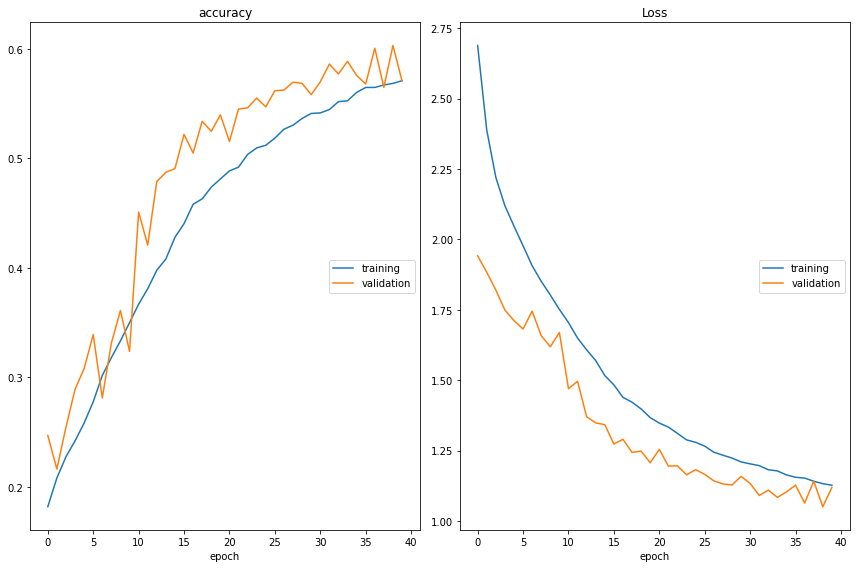

accuracy
	training         	 (min:    0.182, max:    0.571, cur:    0.571)
	validation       	 (min:    0.216, max:    0.603, cur:    0.571)
Loss
	training         	 (min:    1.127, max:    2.688, cur:    1.127)
	validation       	 (min:    1.051, max:    1.941, cur:    1.119)

Epoch 40: val_accuracy did not improve from 0.60296
224/224 [==============================] - 138s 617ms/step - loss: 1.1271 - accuracy: 0.5708 - val_loss: 1.1192 - val_accuracy: 0.5706 - lr: 1.0000e-04


In [31]:
# Load model weights
# model = model.load_weights('weights/input_model_weights_72x72.h5')

# Train model for 72 x 72
checkpoint = ModelCheckpoint('weights/input_model_weights_54x54.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

model_54 = model_54.fit(
    train_generator_54,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator_54,
    validation_steps=validation_steps,
    callbacks=[PlotLossesKeras(), checkpoint, reduce_lr, early_stop]
)

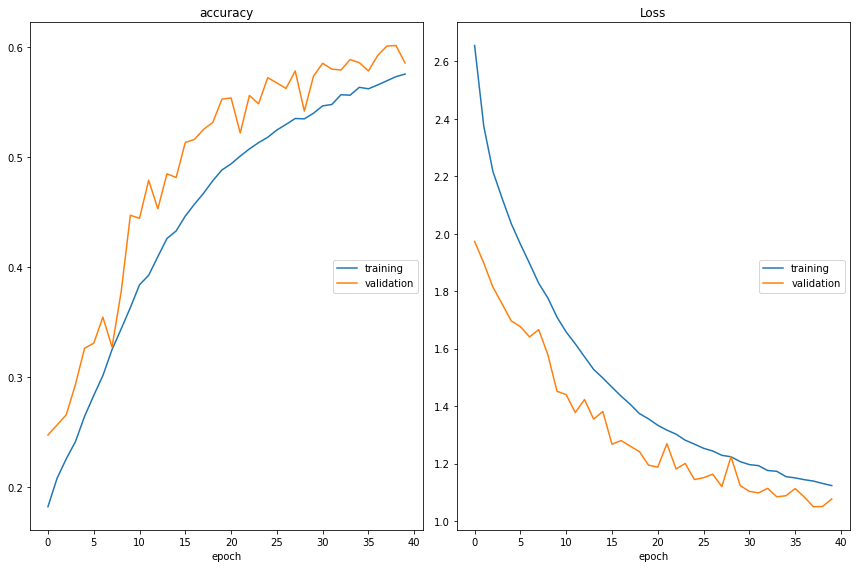

accuracy
	training         	 (min:    0.182, max:    0.576, cur:    0.576)
	validation       	 (min:    0.247, max:    0.602, cur:    0.586)
Loss
	training         	 (min:    1.123, max:    2.656, cur:    1.123)
	validation       	 (min:    1.050, max:    1.974, cur:    1.077)

Epoch 40: val_accuracy did not improve from 0.60156
224/224 [==============================] - 153s 680ms/step - loss: 1.1231 - accuracy: 0.5756 - val_loss: 1.0766 - val_accuracy: 0.5857 - lr: 1.0000e-04


In [32]:
# Train model for 60 x 60
checkpoint = ModelCheckpoint('weights/input_model_weights_60x60.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

model_60 = model_60.fit(
    train_generator_60,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator_60,
    validation_steps=validation_steps,
    callbacks=[PlotLossesKeras(), checkpoint, reduce_lr, early_stop]
)

29/29 [==============================] - 3s 79ms/step
              precision    recall  f1-score   support

       angry       0.45      0.60      0.51       479
     disgust       0.60      0.32      0.42        56
        fear       0.51      0.22      0.31       512
       happy       0.78      0.84      0.81       887
     neutral       0.48      0.57      0.52       617
         sad       0.44      0.44      0.44       624
    surprise       0.78      0.73      0.75       416

    accuracy                           0.58      3591
   macro avg       0.58      0.53      0.54      3591
weighted avg       0.59      0.58      0.57      3591

Precision: 0.5775979732686238
Recall: 0.5324643488807261
F1 Score: 0.5384998399549505
              precision    recall  f1-score   support

       angry       0.43      0.49      0.46       479
     disgust       0.75      0.05      0.10        56
        fear       0.52      0.12      0.19       512
       happy       0.64      0.90      0.74   

c:\Users\subse\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\subse\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\subse\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

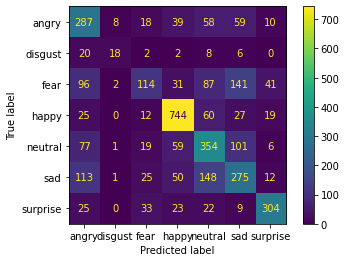

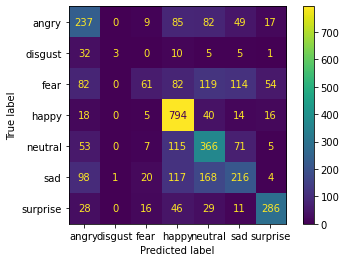

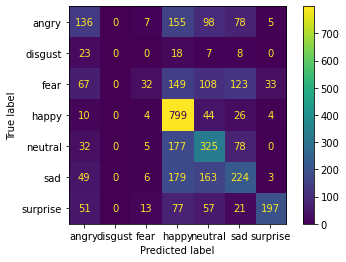

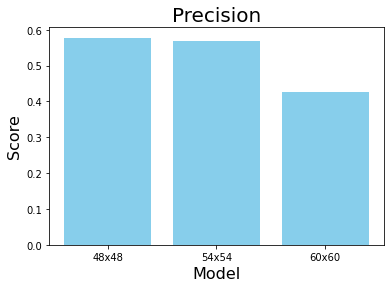

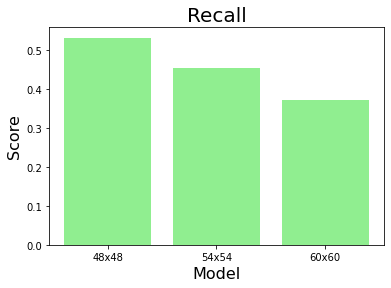

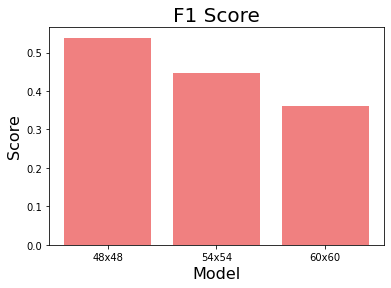

In [11]:
# Load model weights
model_48 = load_model('weights/input_model_weights_48x48.h5')
model_54 = load_model('weights/input_model_weights_54x54.h5')
model_60 = load_model('weights/input_model_weights_60x60.h5')

# Evaluate model
y_pred_48 = model_48.predict(test_generator)
y_pred_54 = model_54.predict(test_generator)
y_pred_60 = model_60.predict(test_generator)

# Calculate metrics
precision_48, recall_48, fscore_48 = calculate_model_metrics(y_true, y_pred_48, classes)
precision_54, recall_54, fscore_54 = calculate_model_metrics(y_true, y_pred_54, classes)
precision_60, recall_60, fscore_60 = calculate_model_metrics(y_true, y_pred_60, classes)

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred_48, classes)
plot_confusion_matrix(y_true, y_pred_54, classes)
plot_confusion_matrix(y_true, y_pred_60, classes)

# Plot precision, recall, f1 score
plt.figure(facecolor='white')
plt.bar(['48x48', '54x54', '60x60'], [precision_48, precision_54, precision_60], color='skyblue')
plt.title('Precision', fontsize=20)
plt.ylabel('Score', fontsize=16)
plt.xlabel('Model', fontsize=16)
plt.show()

plt.figure(facecolor='white')
plt.bar(['48x48', '54x54', '60x60'], [recall_48, recall_54, recall_60], color='lightgreen')
plt.title('Recall', fontsize=20)
plt.ylabel('Score', fontsize=16)
plt.xlabel('Model', fontsize=16)
plt.show()

plt.figure(facecolor='white')
plt.bar(['48x48', '54x54', '60x60'], [fscore_48, fscore_54, fscore_60], color='lightcoral')
plt.title('F1 Score', fontsize=20)
plt.ylabel('Score', fontsize=16)
plt.xlabel('Model', fontsize=16)
plt.show()